
# Ability of Gaussian process regression (GPR) to estimate data noise-level

This example shows the ability of the
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` to estimate the noise
level in the data. Moreover, we show the importance of kernel hyperparameters
initialization.


In [10]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

## Data generation

We will work in a setting where `X` will contain a single feature. We create a
function that will generate the target to be predicted. We will add an
option to add some noise to the generated target.



In [11]:
import numpy as np


def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

Let's have a look to the target generator where we will not add any noise to
observe the signal that we would like to predict.



In [12]:
X = np.linspace(0, 5, num=30).reshape(-1, 1)
y = target_generator(X, add_noise=False)

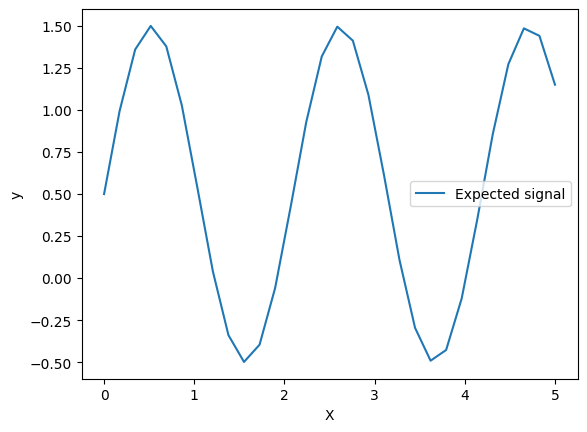

In [13]:
import matplotlib.pyplot as plt

plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

The target is transforming the input `X` using a sine function. Now, we will
generate few noisy training samples. To illustrate the noise level, we will
plot the true signal together with the noisy training samples.



In [14]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

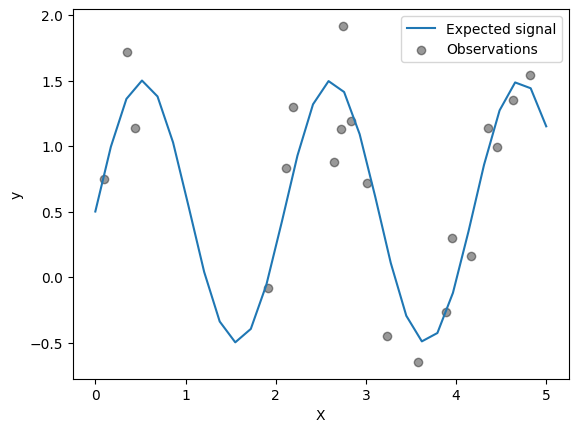

In [15]:
plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_train[:, 0],
    y=y_train,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

In [21]:
!python3 -m pip install scikit-learn

     |████████████████████████████████| 10.4 MB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


## Optimisation of kernel hyperparameters in GPR

Now, we will create a
:class:`~sklearn.gaussian_process.GaussianProcessRegressor`
using an additive kernel adding a
:class:`~sklearn.gaussian_process.kernels.RBF` and
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` kernels.
The :class:`~sklearn.gaussian_process.kernels.WhiteKernel` is a kernel that
will able to estimate the amount of noise present in the data while the
:class:`~sklearn.gaussian_process.kernels.RBF` will serve at fitting the
non-linearity between the data and the target.

However, we will show that the hyperparameter space contains several local
minima. It will highlights the importance of initial hyperparameter values.

We will create a model using a kernel with a high noise level and a large
length scale, which will explain all variations in the data by noise.



In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


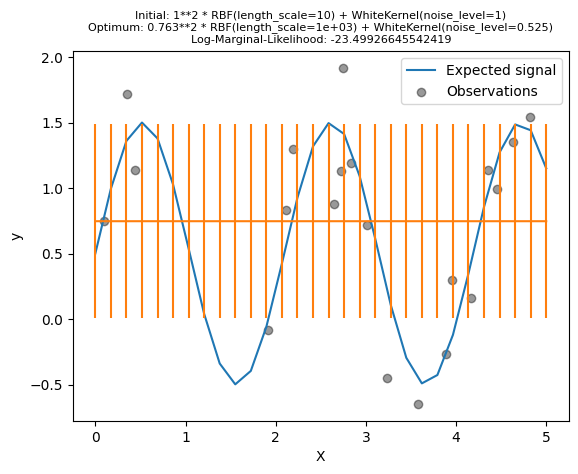

In [23]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
    ),
    fontsize=8,
)

We see that the optimum kernel found still have a high noise level and
an even larger length scale. Furthermore, we observe that the
model does not provide faithful predictions.

Now, we will initialize the
:class:`~sklearn.gaussian_process.kernels.RBF` with a
larger `length_scale` and the
:class:`~sklearn.gaussian_process.kernels.WhiteKernel`
with a smaller noise level lower bound.



In [24]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

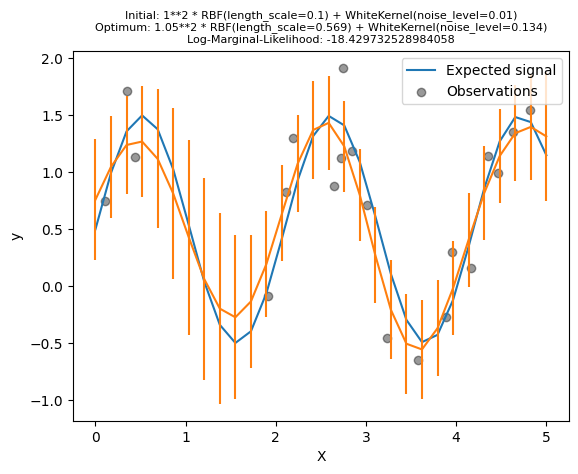

In [25]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
    ),
    fontsize=8,
)

First, we see that the model's predictions are more precise than the
previous model's: this new model is able to estimate the noise-free
functional relationship.

Looking at the kernel hyperparameters, we see that the best combination found
has a smaller noise level and shorter length scale than the first model.

We can inspect the Log-Marginal-Likelihood (LML) of
:class:`~sklearn.gaussian_process.GaussianProcessRegressor`
for different hyperparameters to get a sense of the local minima.



In [26]:
from matplotlib.colors import LogNorm

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

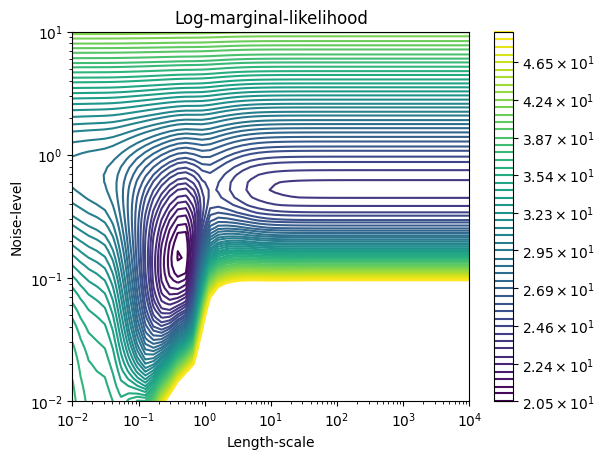

In [27]:
vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

We see that there are two local minima that correspond to the combination
of hyperparameters previously found. Depending on the initial values for the
hyperparameters, the gradient-based optimization might converge whether or
not to the best model. It is thus important to repeat the optimization
several times for different initializations.

